# <center> Линейная регрессия

Это задание посвящено линейной регрессии. На примере прогнозирования роста человека по его весу будет продемонстрирована математика в действии.

## Первичный анализ данных 

В этом задании используются данные [SOCR](http://wiki.stat.ucla.edu/socr/index.php/SOCR_Data_Dinov_020108_HeightsWeights) по росту и весу 25 тысяч подростков.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('data/weights_heights.csv', index_col='Index')

In [3]:
data.head()

,Height,Weight
Index,,
1,65.78331,112.9925
2,71.51521,136.4873
3,69.39874,153.0269
4,68.21660,142.3354
5,67.78781,144.2971


<AxesSubplot:title={'center':'Weight distribution'}, ylabel='Frequency'>

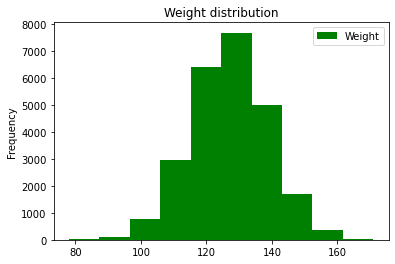

In [4]:
data.plot(y = 'Weight', 
          kind = 'hist',
          color = 'green',
          title = 'Weight distribution'
          )

Создадим признак *Индекс массы тела* ([BMI](https://en.wikipedia.org/wiki/Body_mass_index))

In [5]:
def make_bmi(height_inch, weight_pound):
    METER_TO_INCH, KILO_TO_POUND = 39.37, 2.20462
    return (weight_pound / KILO_TO_POUND) / \
           (height_inch / METER_TO_INCH) ** 2

In [6]:
data['BMI'] = data.apply(lambda row: make_bmi(row['Height'], 
                                              row['Weight']), axis=1)

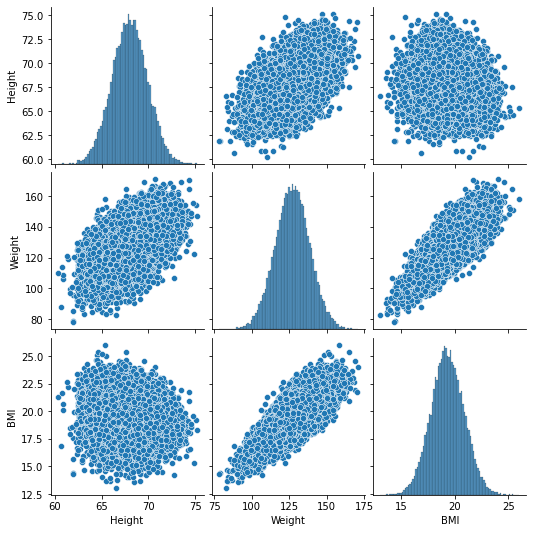

In [7]:
sns.pairplot(data)

Создадим новый признак *weight_category*, который будет иметь 3 значения: 1 – если вес меньше 120 фунтов. (~ 54 кг.), 3 - если вес  больше или равен 150 фунтов (~68 кг.), 2 – в остальных случаях. Построими "ящик с усами".

<AxesSubplot:xlabel='weight_cat', ylabel='Height'>

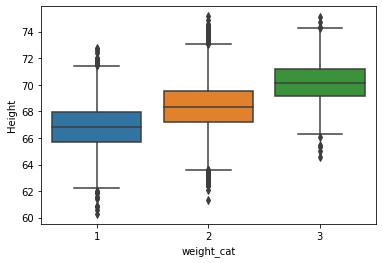

In [8]:
def weight_category(weight):
    if weight < 120:
        return 1
    elif weight >= 150:
        return 3
    else:
        return 2

data['weight_cat'] = data['Weight'].apply(weight_category)
sns.boxplot( x = 'weight_cat', y = 'Height', data = data)

scatter plot зависимости роста от веса.

<AxesSubplot:title={'center':'scatter plot Height(Weight)'}, xlabel='Weight', ylabel='Height'>

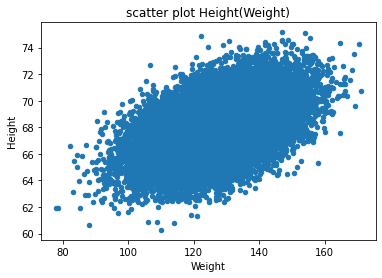

In [9]:
data.plot( x = 'Weight', y = 'Height', kind = 'scatter', title = 'scatter plot Height(Weight)')

## Минимизация квадратичной ошибки

В простейшей постановке задача прогноза значения вещественного признака по прочим признакам (задача восстановления регрессии) решается минимизацией квадратичной функции ошибки. 

Напишим функцию, которая по двум параметрам $w_0$ и $w_1$ вычисляет квадратичную ошибку приближения зависимости роста $y$ от веса $x$ прямой линией $y = w_0 + w_1 * x$:
$$error(w_0, w_1) = \sum_{i=1}^n {(y_i - (w_0 + w_1 * x_i))}^2 $$
Здесь $n$ – число наблюдений в наборе данных, $y_i$ и $x_i$ – рост и вес $i$-ого человека в наборе данных. 

In [10]:
y = list(data['Height'])
x = list(data['Weight'])

def error(w_0, w_1):
    error = 0
    for i in range(len(y)):
        error += (y[i]-(w_0 + w_1*x[i]))**2
    return error
    

Итак, мы решаем задачу: как через облако точек, соответсвующих наблюдениям в нашем наборе данных, в пространстве признаков "Рост" и "Вес" провести прямую линию так, чтобы минимизировать функционал ошибки. Для начала давайте отобразим хоть какие-то прямые и убедимся, что они плохо передают зависимость роста от веса.

Проведем на графике sсatter plot "зависимость роста от веса" две прямые, соответствующие значениям параметров

<center> ($w_0, w_1) = (60, 0.05)$ и ($w_0, w_1) = (50, 0.16)$.

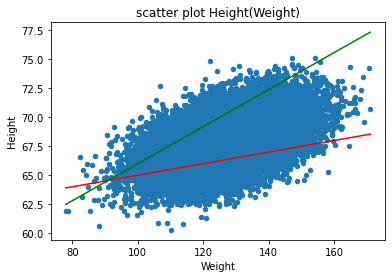

In [11]:
data.plot( x = 'Weight', y = 'Height', kind = 'scatter', title = 'scatter plot Height(Weight)')

x_1 = np.linspace(min(data.Weight),max(data.Weight))
plt.plot(x_1, 60 + 0.05*x_1, color = 'red')
plt.plot(x_1, 50 + 0.16*x_1, color = 'green')

Минимизация квадратичной функции ошибки - относительная простая задача, поскольку функция выпуклая. Для такой задачи существует много методов оптимизации. Посмотрим, как функция ошибки зависит от одного параметра (наклон прямой), если второй параметр (свободный член) зафиксировать.

Построим график зависимости функции ошибки, от параметра $w_1$ при $w_0$ = 50.

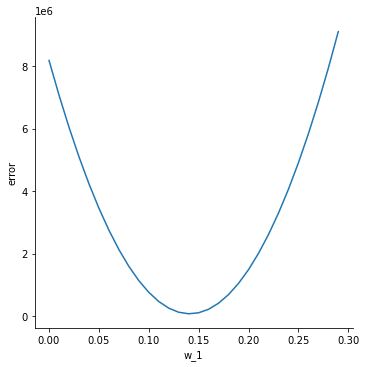

In [12]:
f_error_df = pd.DataFrame({'w_1': np.arange(0,0.3,0.01)})
f_error_df['error'] = f_error_df.w_1.apply(lambda w_1: error(50, w_1))
sns.relplot(
    data = f_error_df,
    kind = 'line',
    x = 'w_1',
    y = 'error'
)

Теперь методом оптимизации найдем "оптимальный" наклон прямой, приближающей зависимость роста от веса, при фиксированном коэффициенте $w_0 = 50$. 

In [13]:
from scipy.optimize import minimize_scalar 

opt = minimize_scalar(lambda w_1: error(50, w_1), bounds = (-5,5))

# Минимум функции ошибки равен 79512
w_1_opt = opt.x

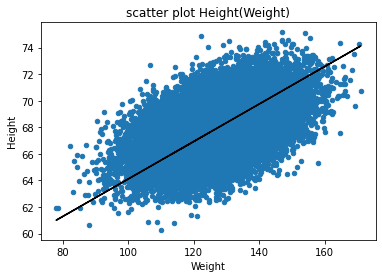

In [14]:
data.plot( x = 'Weight', y = 'Height', kind = 'scatter', title = 'scatter plot Height(Weight)')

plt.plot(data.Weight, 50 + w_1_opt*data.Weight, color = 'black')

При анализе многомерных данных человек часто хочет получить интуитивное представление о природе данных с помощью визуализации. Увы, при числе признаков больше 3 такие картинки нарисовать невозможно. На практике для визуализации данных в 2D и 3D в данных выделаяют 2 или, соответственно, 3 главные компоненты и отображают данные на плоскости или в объеме. 

In [15]:
from mpl_toolkits.mplot3d import Axes3D

Построим 3D-график зависимости функции ошибки от параметров $w_0$ и $w_1$.

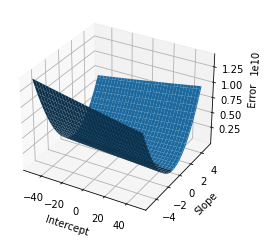

In [16]:
fig = plt.figure()
ax = fig.gca(projection = '3d')
W0=np.arange(-50, 51)
W1=np.linspace(-5,5,101)
W0, W1 = np.meshgrid(W0, W1)
Z=error(W0,W1)
surf = ax.plot_surface(W0, W1, Z)
ax.set_xlabel('Intercept')
ax.set_ylabel('Slope')
ax.set_zlabel('Error')
plt.show()

Найдем минимум функции ошибки для значений параметра $w_0$ в диапазоне [-100,100] и $w_1$ - в диапазоне [-5, 5]. Начальная точка – ($w_0$, $w_1$) = (0, 0). Используемый метод оптимизации L-BFGS-B (аргумент method метода minimize).

In [17]:
# Ваш код здесь
def err(o):
    l = o[1]*data.Weight.to_numpy() + o[0]
    return ((data.Height.to_numpy() - l)**2).sum()

from scipy.optimize import minimize
osst=minimize(err,(0,0),method='L-BFGS-B',bounds=[(-100,100),(-5,5)])
print(osst)

      fun: 67545.28708645458
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.        , -0.00145519])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 36
      nit: 5
     njev: 12
   status: 0
  success: True
        x: array([57.57178489,  0.08200642])


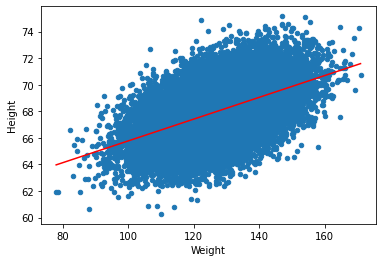

In [18]:
data.plot(x='Weight',y='Height',kind='scatter')
x_1 = np.linspace(min(data.Weight),max(data.Weight))
plt.plot(x_1, 57.5717 + 0.082*x_1, color = 'red')